In [1]:
import matplotlib.pyplot as plt

PART 1 (PROBABLY COMPLETE)

In [2]:
def parse_graph_file(path):
    data = {
        "num_nodes": 0,
        "num_edges": 0,
        "nodes": {},
        "edges": [],
        "office": None,
        "new_nodes": []
    }

    section = None  # NODES, EDGES, OFFICE, NEW
    
    with open(path, "r") as f:
        for line in f:
            line = line.strip()

            # Saltar líneas vacías
            if not line:
                continue

            # 1️⃣ — Leer la primera línea (cantidad nodos y edges)
            if data["num_nodes"] == 0 and data["num_edges"] == 0:
                parts = line.split()
                data["num_nodes"] = int(parts[0])
                data["num_edges"] = int(parts[1])
                continue

            # 2️⃣ — Detectar secciones
            if line.startswith("[") and line.endswith("]"):
                section = line[1:-1]  # quitar corchetes
                continue

            # 3️⃣ — Parsear según la sección activa
            parts = line.split()

            if section == "NODES":
                # formato: id x y is_pump
                node_id = int(parts[0])
                x = float(parts[1])
                y = float(parts[2])
                is_pump = bool(int(parts[3]))
                data["nodes"][node_id] = (x, y, is_pump)

            elif section == "EDGES":
                # formato: u v weight
                u = int(parts[0])
                v = int(parts[1])
                w = float(parts[2])
                data["edges"].append((u, v, w))

            elif section == "OFFICE":
                # formato: single node id
                data["office"] = int(parts[0])

            elif section == "NEW":
                # formato: x y weight
                x = float(parts[0])
                y = float(parts[1])
                w = float(parts[2])
                data["new_nodes"].append((x, y, w))

    return data


In [3]:
#data  = parse_graph_file("FOS.txt")
#data  = parse_graph_file("HAN.txt")
#data  = parse_graph_file("NYT.txt")
data  = parse_graph_file("PES.txt")

print(data["num_nodes"])
print(data["num_edges"])
print(data["nodes"][1])
print(data["edges"][:5])
print(data["office"])
print(data["new_nodes"])


71
99
(656582.88, 963296.25, True)
[(1, 2, 101.0), (3, 4, 153.0), (3, 5, 101.0), (3, 1, 126.0), (6, 7, 101.0)]
51
[(657029.0, 963601.0, 120.0), (662127.0, 961448.0, 105.0)]


PART 2 (COMPLETE)

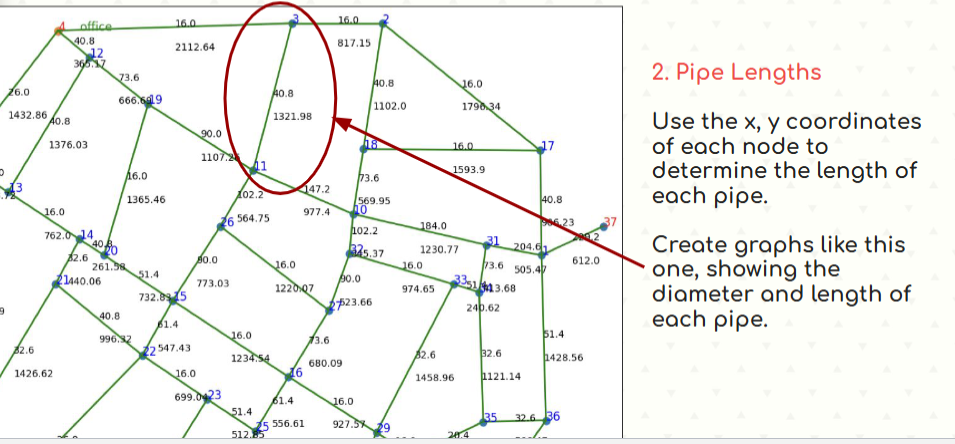

In [4]:
def pipe_length(u, v):
    x1, y1 = u[0], u[1]
    x2, y2 = v[0], v[1]
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

def pipe_graph(data, update_edges=True, return_lengths=False):
    """Compute lengths for each edge and optionally store them in data['edges']."""
    lengths = []
    new_edges = []
    for edge in data["edges"]:
        # support edges that are either (u, v, w) or already (u, v, w, length)
        if len(edge) == 4:
            u, v, w, length = edge
        else:
            u, v, w = edge
            node_u = data["nodes"][u]
            node_v = data["nodes"][v]
            length = pipe_length(node_u, node_v)
        lengths.append((u, v, w, length))
        new_edges.append((u, v, w, length))
    if update_edges:
        data["edges"] = new_edges
    if return_lengths:
        return lengths
    return data

# Compute and store lengths in data['edges'] (each edge becomes (u, v, w, length))
pipe_graph(data)

{'num_nodes': 71,
 'num_edges': 99,
 'nodes': {1: (656582.88, 963296.25, True),
  2: (657289.06, 963069.5, False),
  3: (656852.19, 963283.19, False),
  4: (657294.63, 963262.25, False),
  5: (657933.44, 963588.94, False),
  6: (661346.75, 960658.38, False),
  7: (661252.19, 960607.19, True),
  8: (661547.63, 960688.13, False),
  9: (660262.19, 961842.69, False),
  10: (659947.69, 961952.63, False),
  11: (659120.75, 962107.19, False),
  12: (661689.69, 962215.25, False),
  13: (661623.88, 962717.69, False),
  14: (662482.81, 962917.75, False),
  17: (662131.88, 963005.56, False),
  18: (661006.88, 962760.81, False),
  19: (660673.44, 962792.06, False),
  20: (661012.0, 963102.44, False),
  21: (661221.06, 963474.69, False),
  22: (661856.94, 963711.13, False),
  23: (661860.75, 963473.88, False),
  24: (662326.0, 962957.19, False),
  25: (662031.81, 962086.69, False),
  26: (662135.06, 963007.19, False),
  27: (661853.69, 963051.0, False),
  28: (661141.5, 961352.25, False),
  29: (66

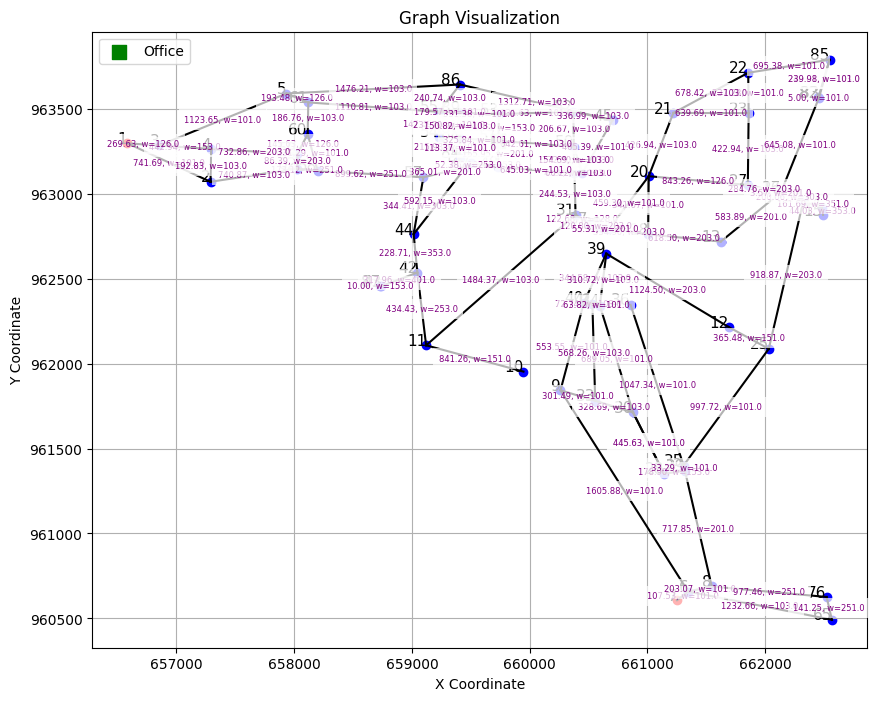

In [5]:
def draw_graph(data, compute_missing=False):
    """Dibuja el grafo usando la longitud almacenada en cada arista si existe.
    Si una arista no tiene longitud y `compute_missing` es True, la longitud se calculará con `pipe_length`.
    """
    plt.figure(figsize=(10, 8))

    # Draw nodes (support (x,y,is_pump) or (id,x,y,is_pump))
    for node_id, node in data["nodes"].items():
        if isinstance(node, (list, tuple)) and len(node) == 3:
            x, y, is_pump = node
        elif isinstance(node, (list, tuple)) and len(node) == 4:
            _, x, y, is_pump = node
        else:
            x, y = node[0], node[1]
            is_pump = False
        color = 'red' if is_pump else 'blue'
        plt.scatter(x, y, c=color)
        plt.text(x, y, str(node_id), fontsize=11, ha='right')

    # Draw edges and annotate with stored length + weight (no recompute by default)
    for edge in data.get("edges", []):
        # Prefer stored length: edge = (u, v, w, length)
        if len(edge) == 4:
            u, v, w, length = edge
        else:
            u, v, w = edge
            length = None
        # get coordinates robustly
        nu = data["nodes"][u]
        nv = data["nodes"][v]
        x1 = nu[0] if len(nu) == 3 else nu[1]
        y1 = nu[1] if len(nu) == 3 else nu[2]
        x2 = nv[0] if len(nv) == 3 else nv[1]
        y2 = nv[1] if len(nv) == 3 else nv[2]
        plt.plot([x1, x2], [y1, y2], 'k-')
        # if length not stored and compute_missing True, compute it
        if length is None and compute_missing:
            length = pipe_length(nu, nv)
        label = f"{length:.2f}, w={w}" if length is not None else f"n/a, w={w}"
        midx, midy = (x1 + x2) / 2, (y1 + y2) / 2
        plt.text(midx, midy, label, fontsize=6, color='purple', ha='center', va='center',
                 backgroundcolor='white', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    # Draw office (if present)
    office_node = data.get("nodes", {}).get(data.get("office"))
    if office_node is not None:
        ox = office_node[0] if len(office_node) == 3 else office_node[1]
        oy = office_node[1] if len(office_node) == 3 else office_node[2]
        plt.scatter(ox, oy, c='green', marker='s', s=100, label='Office')

    plt.title("Graph Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid()
    plt.show()

# By default do not recompute missing lengths
draw_graph(data)

PART 3 

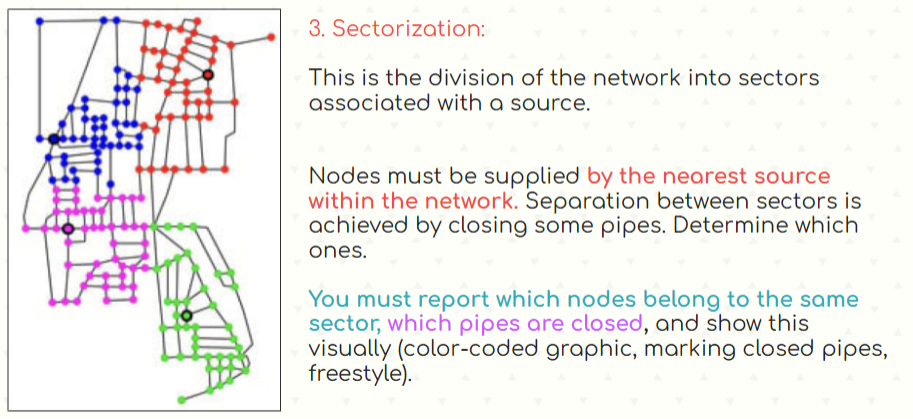

In [6]:
import heapq

def sectorize(data):
    nodes = data["nodes"]
    edges = data["edges"]

    # -----------------------------
    # 1. Construir grafo adjacency list
    # -----------------------------
    graph = {nid: [] for nid in nodes}

    for u, v, w, length in edges:
        graph[u].append((v, length))
        graph[v].append((u, length))

    # -----------------------------
    # 2. Identificar bombas
    # -----------------------------
    pumps = [nid for nid, info in nodes.items() if info[2] == True]

    if not pumps:
        raise ValueError("No hay bombas en la red.")

    # -----------------------------
    # 3. Dijkstra multi-source
    # -----------------------------
    dist = {nid: float("inf") for nid in nodes}
    label = {nid: None for nid in nodes}   # a qué sector/bomba pertenece

    pq = []  # priority queue

    # inicializar bombas
    for pump in pumps:
        dist[pump] = 0
        label[pump] = pump
        heapq.heappush(pq, (0, pump))

    # correr Dijkstra
    while pq:
        current_dist, u = heapq.heappop(pq)

        if current_dist > dist[u]:
            continue

        for v, length in graph[u]:
            new_dist = current_dist + length

            if new_dist < dist[v]:
                dist[v] = new_dist
                label[v] = label[u]  # hereda sector
                heapq.heappush(pq, (new_dist, v))

    # -----------------------------
    # 4. Detectar tuberías que se deben cerrar
    # -----------------------------
    closed_pipes = []
    for u, v, w, length in edges:
        if label[u] != label[v]:
            closed_pipes.append((u, v))

    # -----------------------------
    # 5. Agrupar nodos por sector
    # -----------------------------
    sectors = {}
    for nid, sector_id in label.items():
        sectors.setdefault(sector_id, []).append(nid)

    return {
        "distances": dist,
        "labels": label,
        "sectors": sectors,
        "closed_pipes": closed_pipes
    }


Sectors:
  Sector 1: [1, 2, 3, 4, 5, 10, 11, 19, 31, 32, 37, 38, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 84, 86, 87, 88, 89, 43]
  Sector 7: [6, 7, 8, 9, 12, 13, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 39, 40, 41, 76, 82, 83, 85, 65, 15]
Drawing sector 1 with 38 nodes...


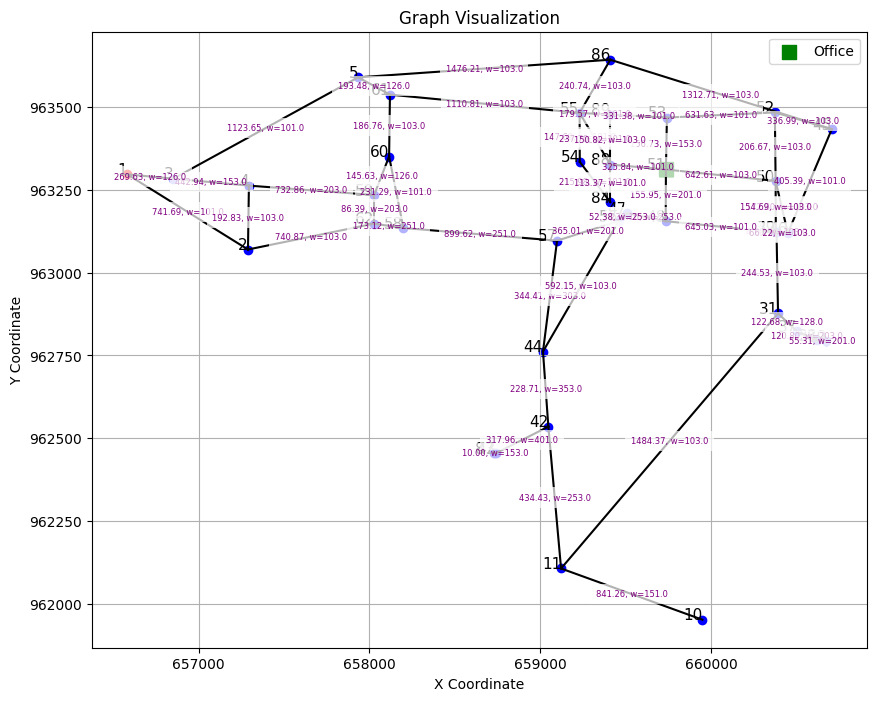

Drawing sector 7 with 33 nodes...


C:\Users\bench\AppData\Local\Temp\ipykernel_17976\2710724702.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


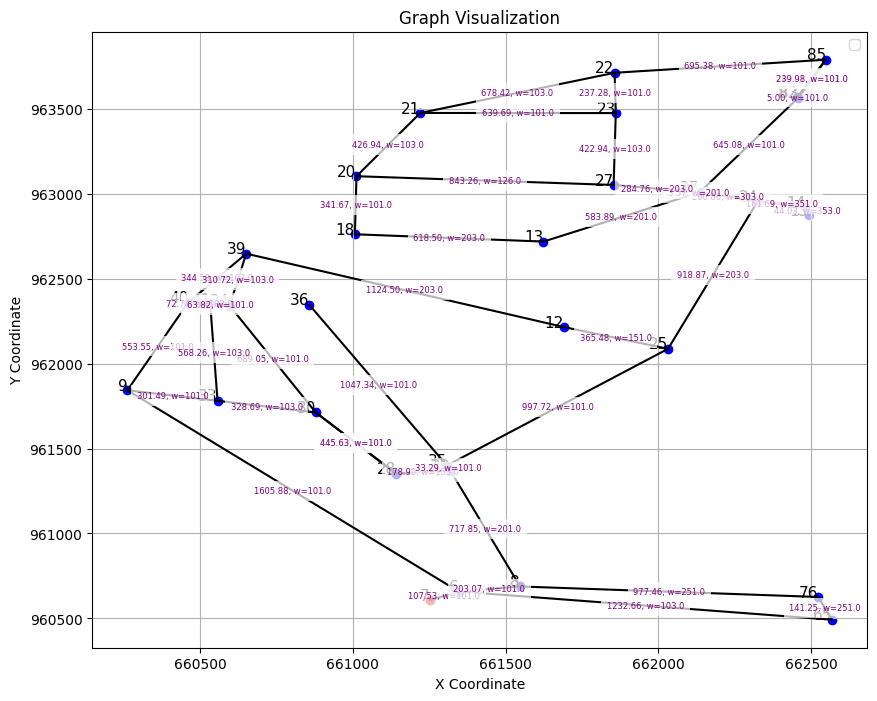

In [7]:
result = sectorize(data)

print("Sectors:")
for pump, nodes in result["sectors"].items():
    print(f"  Sector {pump}: {nodes}")

for pump, nodes in result["sectors"].items():
    subgraph = {
        "nodes": {nid: data["nodes"][nid] for nid in nodes},
        "edges": [e for e in data["edges"] if e[0] in nodes and e[1] in nodes],
        "office": data["office"]
    }
    print(f"Drawing sector {pump} with {len(nodes)} nodes...")
    draw_graph(subgraph)



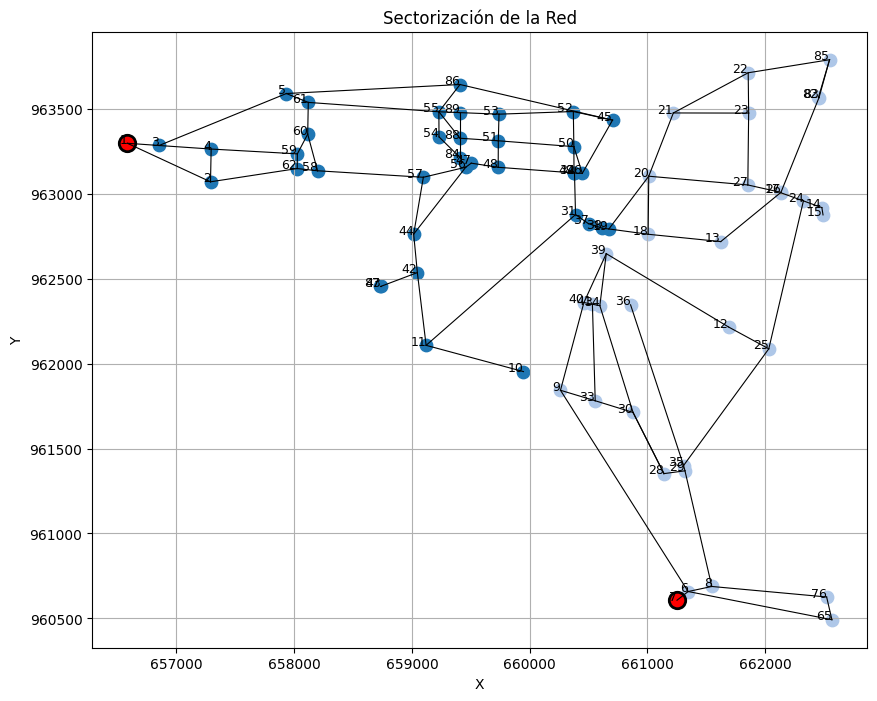

In [8]:
import matplotlib.pyplot as plt
import random

def draw_sectors(data, result):
    nodes = data["nodes"]
    edges = data["edges"]
    labels = result["labels"]
    #closed = set(tuple(sorted(c)) for c in result["closed_pipes"])

    # -------------------------
    # Paleta de colores diferenciados
    # -------------------------
    cmap = plt.get_cmap("tab20")   # 20 colores distintos
    sector_ids = list(result["sectors"].keys())
    
    palette = {}
    for i, sid in enumerate(sector_ids):
        palette[sid] = cmap(i % 20)   # rotar si hay más de 20 sectores

    plt.figure(figsize=(10, 8))

    # -------------------------
    # Dibujar edges
    # -------------------------
    for u, v, w, length in edges:

        nu = nodes[u]
        nv = nodes[v]

        x1, y1 = nu[0], nu[1]
        x2, y2 = nv[0], nv[1]

        # ❌ Si quieres eliminar completamente las líneas rojas:
        # if tuple(sorted((u, v))) in closed:
        #     continue

        # Dejamos todas negras
        plt.plot([x1, x2], [y1, y2], 'k-', linewidth=0.8)

    # -------------------------
    # Dibujar nodos por sector
    # -------------------------
    for nid, (x, y, is_pump) in nodes.items():
        sector = labels[nid]
        color = palette.get(sector, (0.5, 0.5, 0.5))

        if is_pump:
            plt.scatter(x, y, s=140, c='red', edgecolors='black', linewidths=2, marker='o')
        else:
            plt.scatter(x, y, s=80, c=[color], marker='o')

        plt.text(x, y, str(nid), fontsize=9, ha='right')

    plt.title("Sectorización de la Red")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

draw_sectors(data, result)

PART 4 (NEEDS UPDATE)

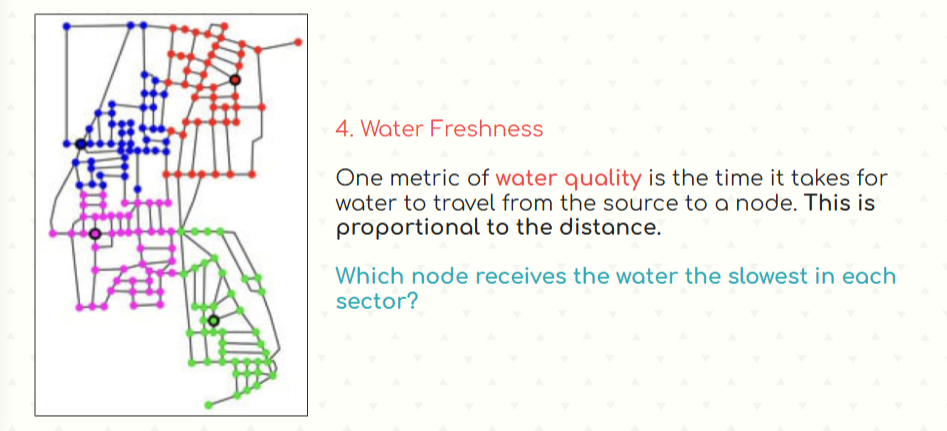


In [9]:
def water_freshness(result, decay_rate=0.1):
    """  Compute water freshness at each node and return sinks per sector.
         Returns (freshness_dict, sinks_by_pump_dict) where sink = node with max distance in sector.
    """
    distances = result["distances"]
    freshness = {}
    for nid, dist in distances.items():
        freshness[nid] = max(0.0, (1.0 - decay_rate) * dist)

    # compute sink (worst node) per sector = node with max distance
    sinks = {}
    for pump, nodes in result["sectors"].items():
        # guard against empty sector
        if not nodes:
            sinks[pump] = None
            continue
        far = None
        max_dist = -float("inf")
        for node in nodes:
            node_dist = distances.get(node, -float("inf"))
            if node_dist > max_dist:
                max_dist = node_dist
                far = node
        sinks[pump] = far

    return freshness, sinks

In [10]:
water_freshness_values, sinks = water_freshness(result, decay_rate=0.05)

print("Sinks (farthest nodes) per sector:")
for pump, sink in sinks.items():
    print(f"  Sector {pump}: Sink Node = {sink}")


Sinks (farthest nodes) per sector:
  Sector 1: Sink Node = 10
  Sector 7: Sink Node = 21


PART 5 (PROBABLY CORRECT)

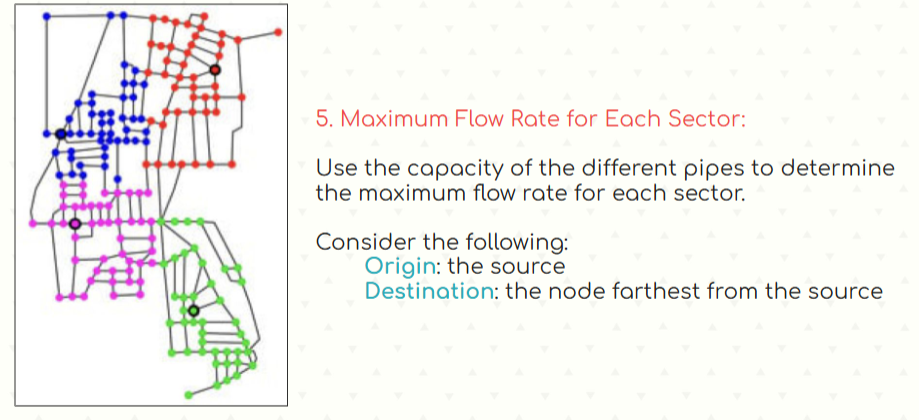

In [11]:
def ford_fulkerson(data, result, sinks):
    from collections import deque

    nodes_data = data["nodes"]
    edges = data["edges"]
    sectors = result["sectors"]

    # Enough size for all nodes
    max_id = max(nodes_data.keys())
    n = max_id + 1

    # build capacity graph (ensure both directions if the graph is undirected) 
    capacity = [[0.0]*n for _ in range(n)]
    for e in edges:
        u, v = e[0], e[1]
        w = e[2] if len(e) >= 3 else 0.0
        # assign in both directions for safety (if your edges are directed, remove the second line)
        capacity[u][v] = w
        capacity[v][u] = w

    def bfs_find_path(residual, s, t):
        parent = [-1]*n
        q = deque([s])
        parent[s] = s
        while q:
            u = q.popleft()
            for v in range(n):
                if parent[v] == -1 and residual[u][v] > 0:
                    parent[v] = u
                    if v == t:
                        # reconstruct path
                        path = []
                        cur = t
                        while cur != s:
                            path.append(cur)
                            cur = parent[cur]
                        path.append(s)
                        path.reverse()
                        return path
                    q.append(v)
        return None

    results = {}
    for pump in sectors.keys():
        sink = sinks.get(pump)
        print(f"[DEBUG] pump={pump}, sink={sink}")
        if sink is None:
            results[pump] = 0
            print("  -> sink None, flow=0")
            continue
        if pump == sink:
            results[pump] = 0
            print("  -> pump == sink, flow=0")
            continue
        if pump not in nodes_data or sink not in nodes_data:
            results[pump] = 0
            print("  -> pump or sink id not in nodes_data, flow=0")
            continue

        # quick reachability check (ignore capacities 0)
        seen = set([pump])
        q = deque([pump])
        reachable = False
        while q:
            u = q.popleft()
            if u == sink:
                reachable = True
                break
            for v in range(n):
                if v not in seen and capacity[u][v] > 0:
                    seen.add(v)
                    q.append(v)
        if not reachable:
            results[pump] = 0
            print("  -> unreachable sink, flow=0")
            continue

        # Edmonds-Karp
        residual = [row[:] for row in capacity]
        max_flow = 0.0
        while True:
            path = bfs_find_path(residual, pump, sink)
            if not path:
                break
            # bottleneck
            bottleneck = min(residual[path[i]][path[i+1]] for i in range(len(path)-1))
            for i in range(len(path)-1):
                u = path[i]; v = path[i+1]
                residual[u][v] -= bottleneck
                residual[v][u] += bottleneck
            max_flow += bottleneck
        results[pump] = max_flow
        print(f"  -> flow={max_flow}")

    return results

In [12]:
max_flows = ford_fulkerson(data, result, sinks)
print("Max flows from pumps to sinks:")
for pump, flow in max_flows.items():
    print(f"  Pump {pump} to Sink {sinks[pump]}: Flow = {flow}")

[DEBUG] pump=1, sink=10
  -> flow=151.0
[DEBUG] pump=7, sink=21
  -> flow=101.0
Max flows from pumps to sinks:
  Pump 1 to Sink 10: Flow = 151.0
  Pump 7 to Sink 21: Flow = 101.0


PART 6 (MISSING)

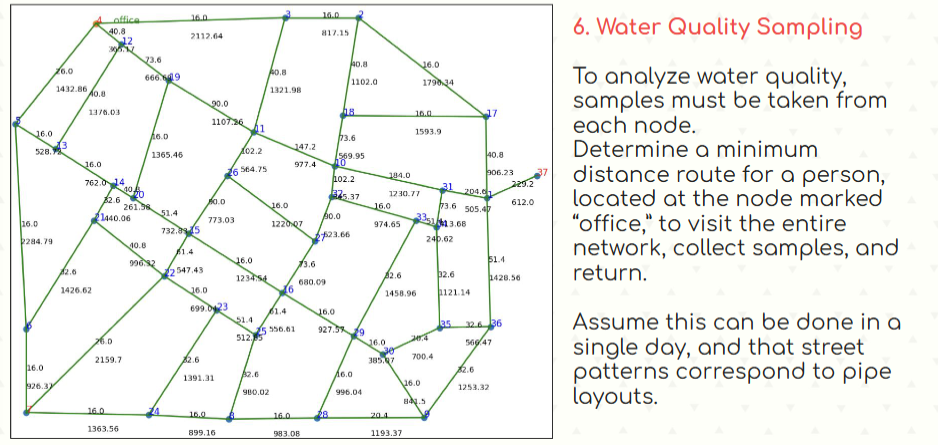

In [13]:
def sampling(data):
    pass

PART 7 (MISSING)

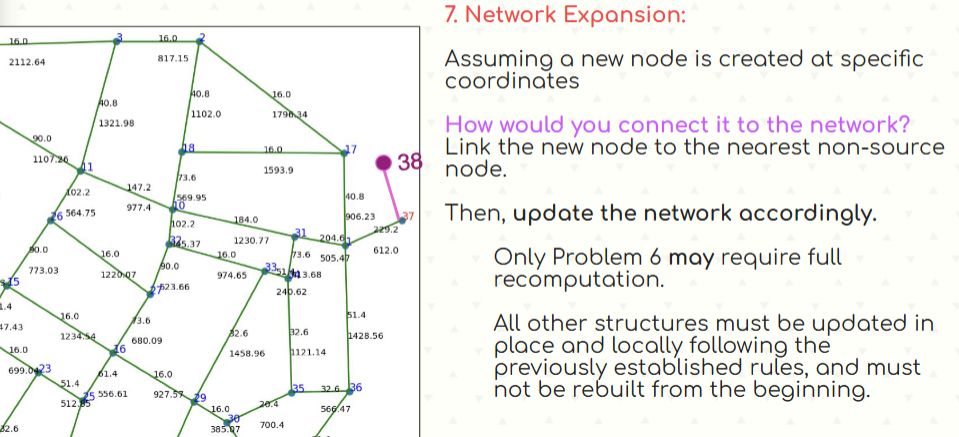

New node 90 connected to 3


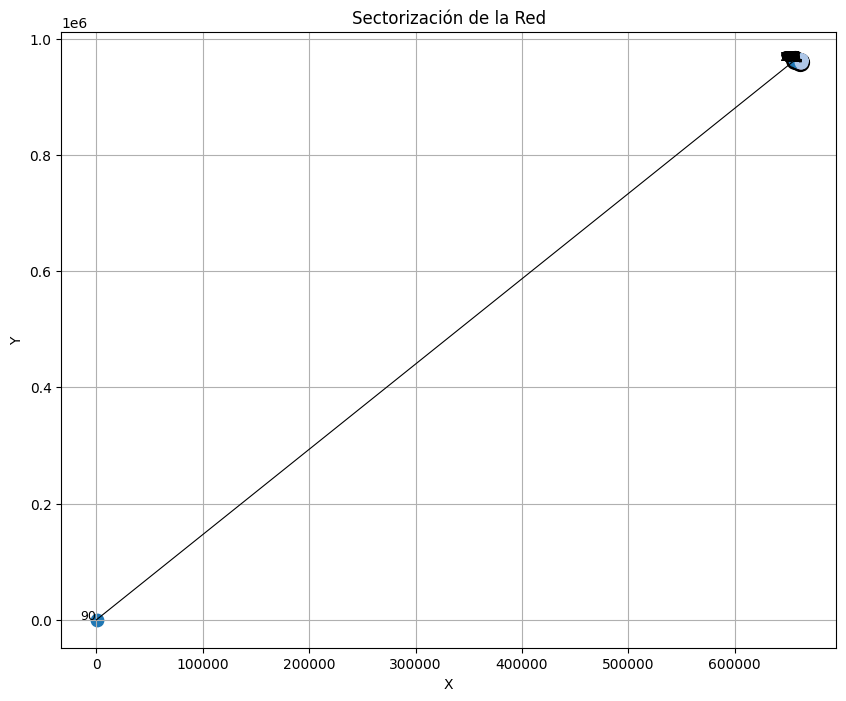

In [14]:
# ...existing code...

def expand_network_add_node(data, result, sinks, x, y, w):
    """
    Add a new node at (x,y) with edge weight w connecting to the nearest non-source node.
    Update `data` and `result` in-place and update `sinks` (dict pump->sink) locally.
    Returns new_node_id, connect_to_id.
    Rules: do not recompute sectorization globally; only update affected structures.
    """
    # helper: distance between coordinate tuples
    def euclid(a, b):
        return ((a[0]-b[0])**2 + (a[1]-b[1])**2) ** 0.5

    # assign new node id (next integer beyond current max id)
    existing_ids = list(data["nodes"].keys())
    new_id = max(existing_ids) + 1 if existing_ids else 0

    # create node tuple (x,y,is_pump=False)
    data["nodes"][new_id] = (float(x), float(y), False)
    data["num_nodes"] = data.get("num_nodes", 0) + 1

    # find nearest non-source node (non-pump). if none, take nearest node.
    nearest_id = None
    nearest_dist = float("inf")
    for nid, node in data["nodes"].items():
        if nid == new_id:
            continue
        is_pump = node[2] if len(node) >= 3 else False
        if is_pump:
            continue  # prefer non-source
        d = euclid((x, y), (node[0], node[1]))
        if d < nearest_dist:
            nearest_dist = d
            nearest_id = nid

    # if no non-source found, pick absolute nearest
    if nearest_id is None:
        for nid, node in data["nodes"].items():
            if nid == new_id:
                continue
            d = euclid((x, y), (node[0], node[1]))
            if d < nearest_dist:
                nearest_dist = d
                nearest_id = nid

    # create edge between nearest_id and new_id
    length = nearest_dist
    edge_tuple = (nearest_id, new_id, float(w), float(length))
    data["edges"].append(edge_tuple)
    data["num_edges"] = data.get("num_edges", 0) + 1

    # Update result (labels, distances, sectors, closed_pipes) in-place
    # if result lacks expected fields, do nothing (safe-guard)
    if result is None:
        return new_id, nearest_id

    labels = result.get("labels")
    distances = result.get("distances")
    sectors = result.get("sectors")
    closed = result.get("closed_pipes")

    # if labels or distances missing, skip updates here
    if labels is None or distances is None or sectors is None:
        return new_id, nearest_id

    # set label and distance for new node based on the neighbor
    neigh_label = labels.get(nearest_id)
    neigh_dist = distances.get(nearest_id, float("inf"))
    if neigh_label is not None and neigh_dist is not None and neigh_dist != float("inf"):
        labels[new_id] = neigh_label
        distances[new_id] = neigh_dist + length
        # add node to its sector
        sectors.setdefault(neigh_label, []).append(new_id)
    else:
        # unreachable from any pump: keep label None and distance inf
        labels[new_id] = None
        distances[new_id] = float("inf")
        sectors.setdefault(None, []).append(new_id)

    # closed_pipes: if the new edge connects nodes of different labels, mark pipe closed
    if closed is not None:
        other_label = labels.get(nearest_id)
        new_label = labels.get(new_id)
        if other_label != new_label:
            closed.append((nearest_id, new_id))

    # Update sinks (worst/farthest nodes) for the sector of neigh_label if needed
    if sinks is not None and neigh_label is not None:
        current_sink = sinks.get(neigh_label)
        current_sink_dist = distances.get(current_sink, -float("inf")) if current_sink is not None else -float("inf")
        if distances[new_id] > current_sink_dist:
            sinks[neigh_label] = new_id

    # remove the added (x,y,w) from data["new_nodes"] if present (optional)
    try:
        data["new_nodes"] = [t for t in data.get("new_nodes", []) if not (abs(t[0]-x) < 1e-12 and abs(t[1]-y) < 1e-12 and abs(t[2]-w) < 1e-12)]
    except Exception:
        pass

    return new_id, nearest_id

# ...existing code...
# add one of the candidates (or any coords)
nxid, connected_to = expand_network_add_node(data, result, sinks, x=12.34, y=56.78, w=1.5)
print("New node", nxid, "connected to", connected_to)
# redraw sector visualization quickly:
draw_sectors(data, result)

BASURITA


In [15]:
def ford_fulkerson(result, source, sink):
    n = len(result["nodes"])
    # Construir grafo de capacidad
    capacity_graph = [[0]*n for _ in range(n)]
    for u, v, w, length in result["edges"]:
        capacity_graph[u][v] = w  # Asignar capacidad

    residual_graph = [row[:] for row in capacity_graph]  # Crear grafo residual
    max_flow = 0

    def dfs(u, path_flow, visited, sink, path):
        visited.add(u)
        path.append(u)

        if u == sink:
            return path_flow

        for v in range(n):
            if v not in visited and residual_graph[u][v] > 0:
                min_flow = min(path_flow, residual_graph[u][v])
                flow = dfs(v, min_flow, visited, sink, path)
                if flow > 0:
                    return flow
        path.pop()  # Backtrack si no se encuentra camino desde el nodo actual
        return 0

    while True:
        visited = set()
        path = []
        flow = dfs(source, float('inf'), visited, sink, path)

        if flow == 0:
            break

        max_flow += flow
        # Actualizar capacidades residuales de las aristas y aristas inversas
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            residual_graph[u][v] -= flow
            residual_graph[v][u] += flow

    return max_flow



In [16]:
def ford_fulkerson(data, result):
    nodes_data = data["nodes"]
    edges = data["edges"]
    labels = result["labels"]
    sectors = result["sectors"]
    distances = result["distances"]
    pump_nodes = []
    sink = []
    n = len(nodes_data)
    capacity_graph = [[0]*n for _ in range(n)]

    for pump, nodes in sectors.items():
        pump_nodes.append(pump)
        far_node = None
        far_dist = float('-inf')
        for no in nodes:
            d = distances.get(no, float('-inf'))
            if d > far_dist:
                far_dist = d
                far_node = no
        sink.append(far_node)
                



    def dfs(u, residual_graph, path_flow, visited, sink, path):
        visited.add(u)
        path.append(u)
        print(u)
        if u == sink:
            return path_flow

        for v in range(n):
          print(v)
          print(n)
          if v not in visited and residual_graph[u][v] > 0:
                min_flow = min(path_flow, residual_graph[u][v])
                flow = dfs(v, residual_graph, min_flow, visited, sink, path)
                if flow > 0:
                    return flow
        path.pop() # Backtrack if no path is found from the current node
        return 0
  
    return capacity_graph, pump_nodes, sink


In [17]:
# ...existing code...
def ford_fulkerson2(data, result, sinks):
    nodes_data = data["nodes"]
    edges = data["edges"]
    labels = result["labels"]
    sectors = result["sectors"]
    distances = result["distances"]

    pump_nodes = list(sectors.keys())
    sink_list = [sinks.get(p) for p in pump_nodes]

    # asegurar tamaño suficiente según el mayor id de nodo en los datos
    max_id = max(nodes_data.keys())
    n = max_id + 1
    capacity_graph = [[0]*n for _ in range(n)]

    # llenar capacidades desde edges (soportando (u,v,w) o (u,v,w,length))
    for e in edges:
        u, v = e[0], e[1]
        w = e[2] if len(e) >= 3 else 0
        capacity_graph[u][v] = w

    # correr FF por cada bomba -> su sink (si existe)
    results = {}
    for pump in pump_nodes:
        sink = sinks.get(pump)
        if sink is None:
            results[pump] = 0
            continue

        residual = [row[:] for row in capacity_graph]
        max_flow = 0

        def dfs(u, t, f, visited, path):
            visited.add(u)
            if u == t:
                return f
            for v in range(len(residual)):
                if v not in visited and residual[u][v] > 0:
                    minf = min(f, residual[u][v])
                    pushed = dfs(v, t, minf, visited, path)
                    if pushed:
                        residual[u][v] -= pushed
                        residual[v][u] += pushed
                        return pushed
            return 0

        while True:
            visited = set()
            pushed = dfs(pump, sink, float("inf"), visited, [])
            if not pushed:
                break
            max_flow += pushed

        results[pump] = max_flow

    return results
# ...existing code...

In [18]:
def ford_fulkerson1(data, result, sinks):
    """Ford-Fulkerson per sector where `sinks` is a dict {pump: sink_node} provided externally."""
    nodes_data = data["nodes"]
    edges = data["edges"]
    labels = result["labels"]
    sectors = result["sectors"]
    distances = result["distances"]

    pump_nodes = list(sectors.keys())
    # use provided sinks (dict) -> build list aligned with pump_nodes if needed
    sink_list = [sinks.get(p) for p in pump_nodes]

    n = len(nodes_data) + 1  # si tus nodos empiezan en 1, reserva n+1
    capacity_graph = [[0]*n for _ in range(n)]

    # llenar capacidades desde edges (suponiendo (u,v,w, length))
    for e in edges:
        if len(e) >= 3:
            u, v, w = e[0], e[1], e[2]
            # ajustar indices según tu convención (si nodes ids no son 0..n-1, mapear)
            capacity_graph[u][v] = w

    # ejemplo simple: si quieres correr FF entre cada pump y su sink
    results = {}
    for pump in pump_nodes:
        sink = sinks.get(pump)
        if sink is None:
            results[pump] = 0
            continue

        # crear copia residual
        residual = [row[:] for row in capacity_graph]
        max_flow = 0

        def dfs(u, t, f, visited, path):
            visited.add(u)
            if u == t:
                return f
            for v in range(len(residual)):
                if v not in visited and residual[u][v] > 0:
                    minf = min(f, residual[u][v])
                    pushed = dfs(v, t, minf, visited, path)
                    if pushed:
                        # actualizar aquí a medida que sube la recursión
                        residual[u][v] -= pushed
                        residual[v][u] += pushed
                        return pushed
            return 0

        while True:
            visited = set()
            pushed = dfs(pump, sink, float("inf"), visited, [])
            if not pushed:
                break
            max_flow += pushed

        results[pump] = max_flow

    return results